咱们的基金是否存在着明显的周内效应呢？就是特定周几盈利高一些，让我们来验证一下吧。

In [1]:
import pandas as pd
from datetime import datetime
import trdb2py

isStaticImg = True
width = 960
height = 768

trdb2cfg = trdb2py.loadConfig('./trdb2.yaml')

我们先指定一个特定的基金，特定的时间段来分析吧。

In [2]:
# 具体基金
asset = 'jrj.270042'

# 起始时间，0表示从最开始算起
tsStart = 0
# tsStart = trdb2py.str2timestamp('2019-01-01', '%Y-%m-%d')

# 结束时间，-1表示到现在为止
tsEnd = -1
# tsEnd = trdb2py.str2timestamp('2020-01-01', '%Y-%m-%d')

# 初始资金池
paramsinit = trdb2py.trading2_pb2.InitParams(
    money=10000,
)

# 买入参数，用全部的钱来买入（也就是复利）
paramsbuy = trdb2py.trading2_pb2.BuyParams(
    perHandMoney=1,
)

# 卖出参数，全部卖出
paramssell = trdb2py.trading2_pb2.SellParams(
    perVolume=1,
)

首先看看这个基金的基准表现，就是在开始时间就直接买入，然后一直持有，看具体的收益率。

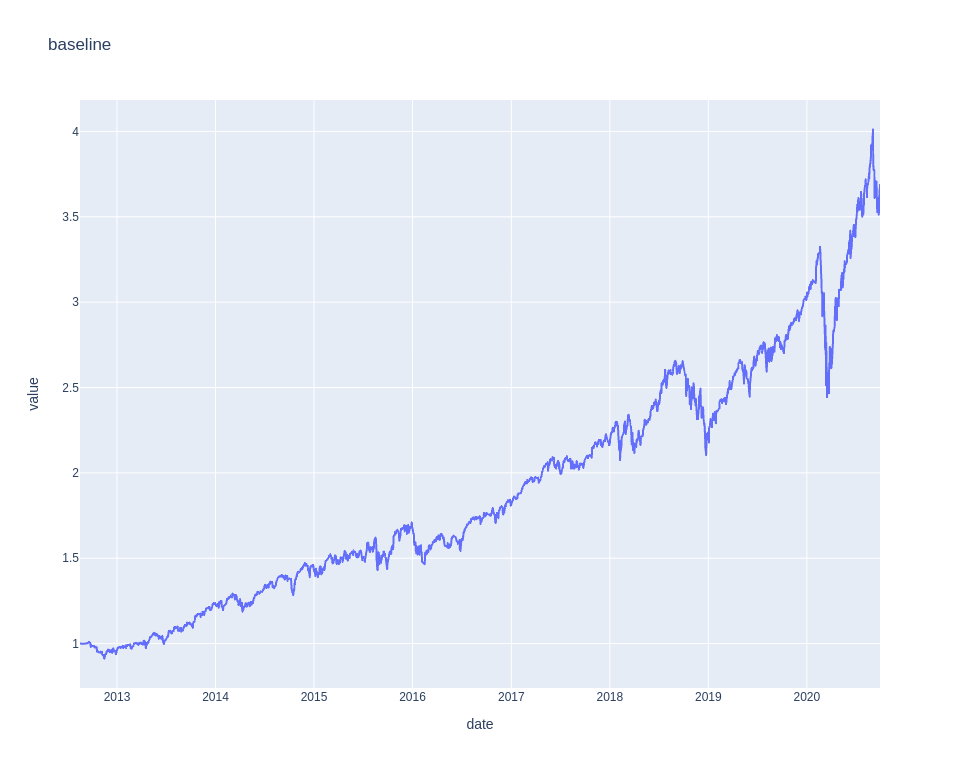

In [3]:
# baseline    
s0 = trdb2py.trading2_pb2.Strategy(
    name="normal",
    asset=trdb2py.str2asset(asset),         
)
        
buy0 = trdb2py.trading2_pb2.CtrlCondition(
    name='buyandhold',
)

paramsbuy = trdb2py.trading2_pb2.BuyParams(
    perHandMoney=1,
)

paramsinit = trdb2py.trading2_pb2.InitParams(
    money=10000,
)

s0.buy.extend([buy0])
s0.paramsBuy.CopyFrom(paramsbuy)
s0.paramsInit.CopyFrom(paramsinit)        
p0 = trdb2py.trading2_pb2.SimTradingParams(
    assets=[trdb2py.str2asset(asset)],
    startTs=tsStart,
    endTs=tsEnd,
    strategies=[s0],
    title='baseline',
)  

pnlBaseline = trdb2py.simTrading(trdb2cfg, p0)
trdb2py.showPNL(pnlBaseline, toImg=isStaticImg, width=width, height=height)

那么策略基准线大概就是这样了，7年多的时间4倍。

纳斯达克太强了

接下来，先看看最简单的情况，就是特定周几买入，第二天就卖出，只持有1天。

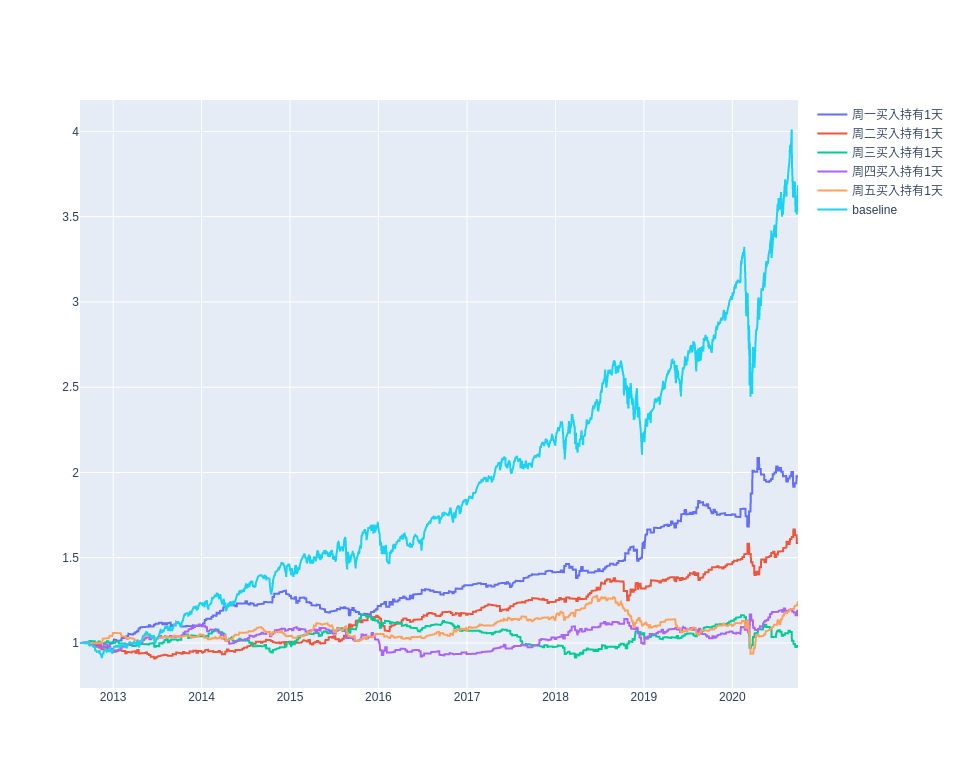

In [4]:
lststart = [1, 2, 3, 4, 5]
lsttitle = ['周一', '周二', '周三', '周四', '周五']
lstparams = []

for i in range(0, 5):
    buy0 = trdb2py.trading2_pb2.CtrlCondition(
        name='weekday',
        vals=[lststart[i]],
    )

    sell0 = trdb2py.trading2_pb2.CtrlCondition(
        name='weekday',
        vals=[trdb2py.nextWeekDay(lststart[i], 1)],
    )

    s0 = trdb2py.trading2_pb2.Strategy(
        name="normal",
        asset=trdb2py.str2asset(asset),
    )

    s0.buy.extend([buy0])
    s0.sell.extend([sell0])
    s0.paramsBuy.CopyFrom(paramsbuy)
    s0.paramsSell.CopyFrom(paramssell)
    s0.paramsInit.CopyFrom(paramsinit)        
    lstparams.append(trdb2py.trading2_pb2.SimTradingParams(
        assets=[trdb2py.str2asset(asset)],
        startTs=tsStart,
        endTs=tsEnd,
        strategies=[s0],
        title='{}买入持有{}天'.format(lsttitle[i], 1),
    ))
 
lstpnl1 = trdb2py.simTradings(trdb2cfg, lstparams)

trdb2py.showPNLs(lstpnl1 + [pnlBaseline], toImg=isStaticImg, width=width, height=height)

如果看曲线图不是很清楚的话，我们列表看看

In [5]:
dfpnl1b = trdb2py.buildPNLReport(lstpnl1 + [pnlBaseline])

dfpnl1b[['title', 'maxDrawdown', 'maxDrawdownStart', 'maxDrawdownEnd', 'totalReturns', 'sharpe', 'annualizedReturns', 'annualizedVolatility', 'variance']].sort_values(by='totalReturns', ascending=False)

,title,maxDrawdown,maxDrawdownStart,maxDrawdownEnd,totalReturns,sharpe,annualizedReturns,annualizedVolatility,variance
5,baseline,0.264906,2020-02-19,2020-03-16,3.686000,1.671637,0.330223,0.179598,0.486164
0,周一买入持有1天,0.110108,2014-12-09,2015-09-07,1.977218,1.106090,0.120141,0.081496,0.071195
1,周二买入持有1天,0.115856,2020-03-04,2020-04-07,1.587032,0.564304,0.072171,0.074731,0.036279
4,周五买入持有1天,0.268258,2018-06-20,2020-03-20,1.245705,0.002278,0.030208,0.091106,0.003963
3,周四买入持有1天,0.170187,2013-12-20,2016-06-30,1.189032,-0.082831,0.023240,0.081612,0.003806
2,周三买入持有1天,0.215949,2015-10-22,2018-03-28,0.982959,-0.377606,-0.002095,0.084996,0.002790


我看可以看到，基线的数据其实已经不错了，夏普能到1.6，最大回撤也只有26%，所有单日策略和基线完全没法打。

上面的策略比较简单，因为有些节假日交易日，所以可能会出现买入了，但无法及时卖出的情况，下面我们换一个确定能卖出才买入的策略看看

In [6]:
def calcweekday2val2(wday, offday):
    if offday == 1:
        if wday == 5:
            return 3
    if offday == 2:
        if wday >= 4:
            return 4
    if offday == 3:
        if wday >= 3:
            return 5
    if offday == 4:
        if wday >= 2:
            return 6
        
    return offday


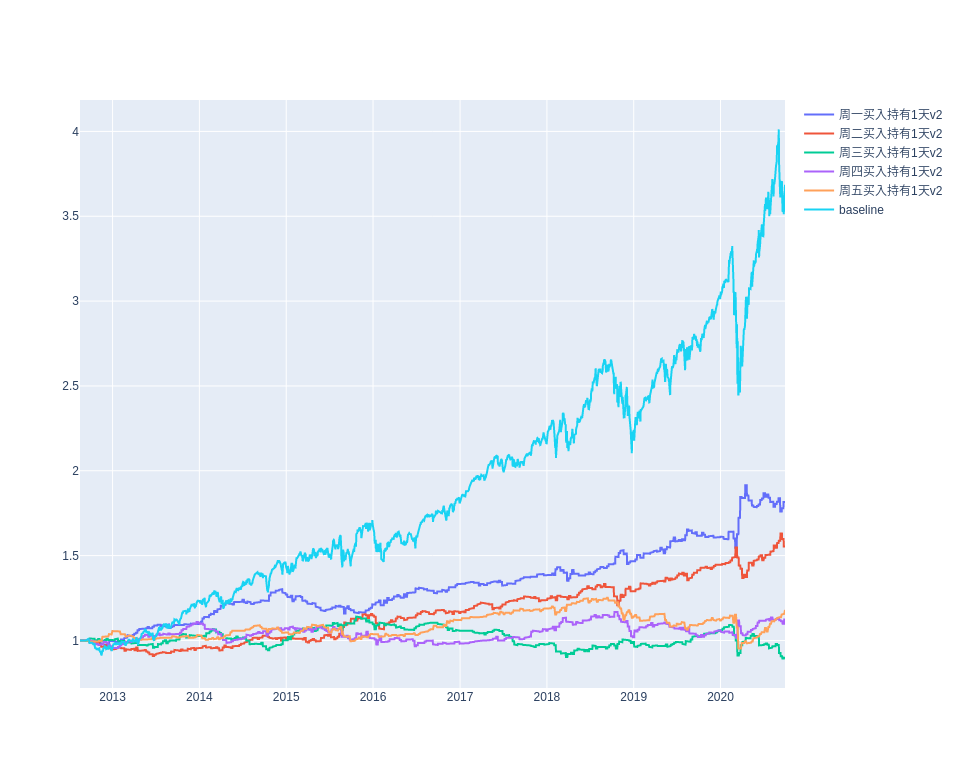

In [7]:
lststart = [1, 2, 3, 4, 5]
lstval2 = [1, 1, 1, 1, 3]
lsttitle = ['周一', '周二', '周三', '周四', '周五']
lstparams = []

for i in range(0, 5):
    buy0 = trdb2py.trading2_pb2.CtrlCondition(
        name='weekday2',
        vals=[lststart[i], calcweekday2val2(i + 1, 1)],
    )

    sell0 = trdb2py.trading2_pb2.CtrlCondition(
        name='weekday',
        vals=[trdb2py.nextWeekDay(lststart[i], 1)],
    )

    s0 = trdb2py.trading2_pb2.Strategy(
        name="normal",
        asset=trdb2py.str2asset(asset),
    )

    s0.buy.extend([buy0])
    s0.sell.extend([sell0])
    s0.paramsBuy.CopyFrom(paramsbuy)
    s0.paramsSell.CopyFrom(paramssell)
    s0.paramsInit.CopyFrom(paramsinit)        
    lstparams.append(trdb2py.trading2_pb2.SimTradingParams(
        assets=[trdb2py.str2asset(asset)],
        startTs=tsStart,
        endTs=tsEnd,
        strategies=[s0],
        title='{}买入持有{}天v2'.format(lsttitle[i], 1),
    ))
 
lstpnl1t = trdb2py.simTradings(trdb2cfg, lstparams)

trdb2py.showPNLs(lstpnl1t + [pnlBaseline], toImg=isStaticImg, width=width, height=height)

In [8]:
dfpnl1b = trdb2py.buildPNLReport(lstpnl1 + lstpnl1t + [pnlBaseline])

dfpnl1b[['title', 'maxDrawdown', 'maxDrawdownStart', 'maxDrawdownEnd', 'totalReturns', 'sharpe', 'annualizedReturns', 'annualizedVolatility', 'variance']].sort_values(by='totalReturns', ascending=False)

,title,maxDrawdown,maxDrawdownStart,maxDrawdownEnd,totalReturns,sharpe,annualizedReturns,annualizedVolatility,variance
10,baseline,0.264906,2020-02-19,2020-03-16,3.686000,1.671637,0.330223,0.179598,0.486164
0,周一买入持有1天,0.110108,2014-12-09,2015-09-07,1.977218,1.106090,0.120141,0.081496,0.071195
5,周一买入持有1天v2,0.110108,2014-12-09,2015-09-07,1.815570,0.919333,0.100268,0.076434,0.045558
1,周二买入持有1天,0.115856,2020-03-04,2020-04-07,1.587032,0.564304,0.072171,0.074731,0.036279
6,周二买入持有1天v2,0.115856,2020-03-04,2020-04-07,1.553156,0.521558,0.068006,0.072871,0.032000
4,周五买入持有1天,0.268258,2018-06-20,2020-03-20,1.245705,0.002278,0.030208,0.091106,0.003963
3,周四买入持有1天,0.170187,2013-12-20,2016-06-30,1.189032,-0.082831,0.023240,0.081612,0.003806
9,周五买入持有1天v2,0.238908,2018-09-10,2020-03-20,1.179994,-0.095237,0.022129,0.082648,0.004822
8,周四买入持有1天v2,0.129584,2018-10-12,2020-03-12,1.122912,-0.193142,0.015111,0.077088,0.002164
2,周三买入持有1天,0.215949,2015-10-22,2018-03-28,0.982959,-0.377606,-0.002095,0.084996,0.002790


可以看到，虽然有一些差别，但其实影响有好有坏，下面我们还是按v2版的策略来吧

接下来看看胜率

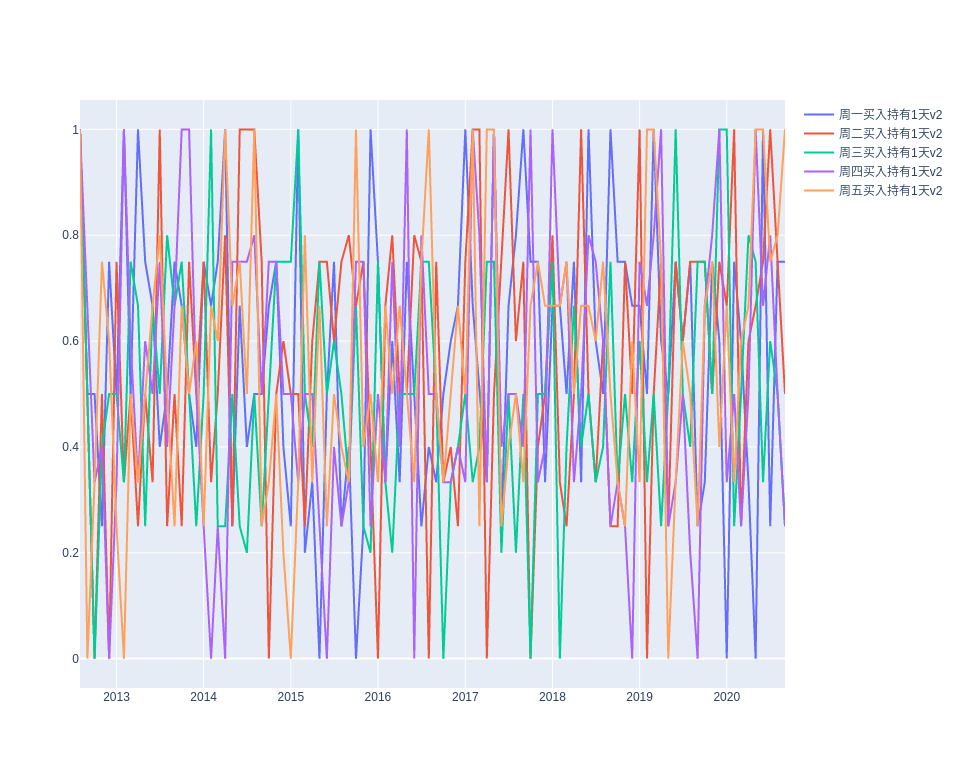

In [9]:
trdb2py.showWinRateInMonths(lstpnl1t, toImg=isStaticImg, width=width, height=height)

对于这种随机策略，胜率应该均匀分布在0.5左右的。

看起来纳斯达克指数比沪深300还是要稳定很多的。

干脆把持有1天到4天的情况，也就是从周一买周二卖，一直到 周一买周五卖，看看

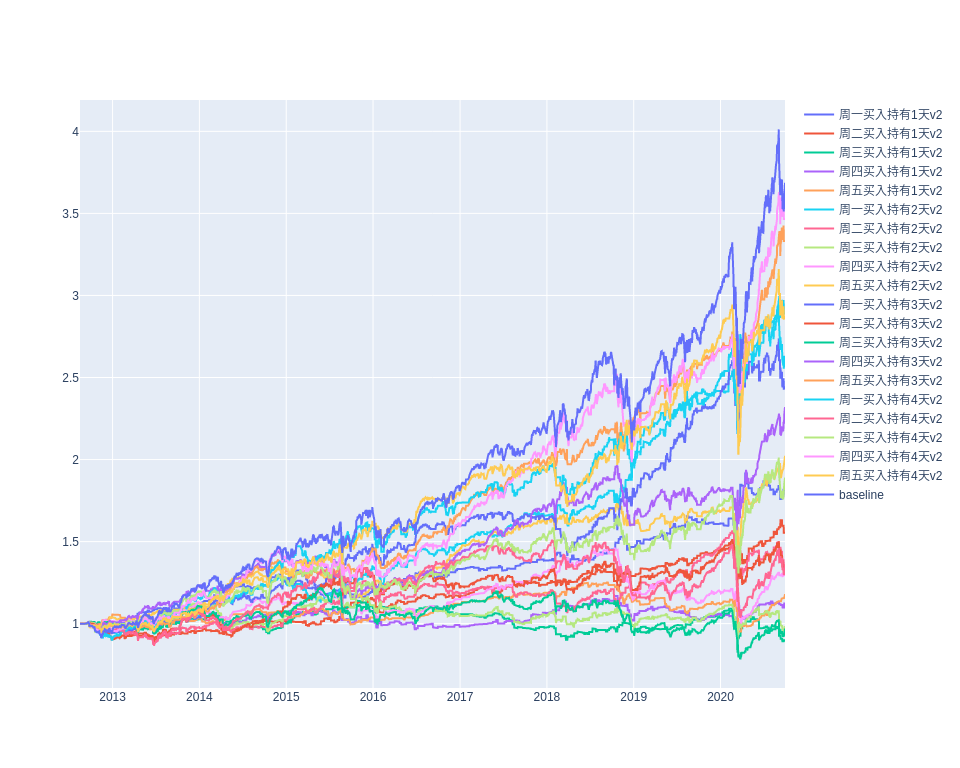

In [10]:
lststart = [1, 2, 3, 4, 5]
lstval2 = [1, 1, 1, 1, 3]
lsttitle = ['周一', '周二', '周三', '周四', '周五']
lstparams = []

for day in range(1, 5):
    for i in range(0, 5):
        buy0 = trdb2py.trading2_pb2.CtrlCondition(
            name='weekday2',
            vals=[lststart[i], calcweekday2val2(i + 1, day)],
        )

        sell0 = trdb2py.trading2_pb2.CtrlCondition(
            name='weekday',
            vals=[trdb2py.nextWeekDay(lststart[i], day)],
        )

        s0 = trdb2py.trading2_pb2.Strategy(
            name="normal",
            asset=trdb2py.str2asset(asset),
        )

        s0.buy.extend([buy0])
        s0.sell.extend([sell0])
        s0.paramsBuy.CopyFrom(paramsbuy)
        s0.paramsSell.CopyFrom(paramssell)
        s0.paramsInit.CopyFrom(paramsinit)        
        lstparams.append(trdb2py.trading2_pb2.SimTradingParams(
            assets=[trdb2py.str2asset(asset)],
            startTs=tsStart,
            endTs=tsEnd,
            strategies=[s0],
            title='{}买入持有{}天v2'.format(lsttitle[i], day),
        ))
 
lstpnl = trdb2py.simTradings(trdb2cfg, lstparams)

trdb2py.showPNLs(lstpnl + [pnlBaseline], toImg=isStaticImg, width=width, height=height)

In [11]:
dfpnl = trdb2py.buildPNLReport(lstpnl + [pnlBaseline])

dfpnl[['title', 'maxDrawdown', 'maxDrawdownStart', 'maxDrawdownEnd', 'totalReturns', 'sharpe', 'annualizedReturns', 'annualizedVolatility', 'variance']].sort_values(by='totalReturns', ascending=False)

,title,maxDrawdown,maxDrawdownStart,maxDrawdownEnd,totalReturns,sharpe,annualizedReturns,annualizedVolatility,variance
20,baseline,0.264906,2020-02-19,2020-03-16,3.686000,1.671637,0.330223,0.179598,0.486164
18,周四买入持有4天v2,0.212902,2018-10-22,2018-12-24,3.465403,1.788954,0.303102,0.152660,0.400466
14,周五买入持有3天v2,0.175740,2020-02-19,2020-03-16,3.331326,1.939244,0.286619,0.132329,0.369523
5,周一买入持有2天v2,0.123159,2014-12-09,2015-05-26,2.889615,1.926584,0.232314,0.105012,0.283695
19,周五买入持有4天v2,0.310720,2020-02-19,2020-03-16,2.870171,1.318643,0.229923,0.151613,0.312301
15,周一买入持有4天v2,0.195695,2020-02-19,2020-03-12,2.626725,1.152030,0.199993,0.147560,0.258106
10,周一买入持有3天v2,0.170643,2020-02-19,2020-03-16,2.441030,1.137468,0.177164,0.129378,0.214532
13,周四买入持有3天v2,0.204324,2014-11-28,2015-10-15,2.320368,0.972793,0.162329,0.136030,0.090942
9,周五买入持有2天v2,0.187065,2018-10-22,2020-03-16,2.022499,0.851130,0.125709,0.112449,0.060965
17,周三买入持有4天v2,0.265587,2020-02-18,2020-03-16,1.889561,0.504770,0.109365,0.157230,0.050543


单看回报率，还是和基线没法打，只有少数波动率降下来，夏普能有一些提升而已。

A股里，其实也有这样的整体都是增长的走势，而且总回报比这个还要高，但也能得出明显的周内效应结论。